In [1]:
import numpy as np
import matplotlib.pyplot as plt

Try to implement a Nnet that is:

Inputs -> FC -> ReLU -> FC -> Softmax

In [2]:
def relu(x, derivative = False):
    res = x
    if derivative == True:
        return (res > 0)*1
    else:
        return res * (res > 0)

def sigmoid(x, derivative = False):
    res = 1/(1 + np.exp(-x))
    if derivative == True:
        return res * (1 - res)
    else:
        return res

In [3]:
INPUT_SIZE = 3
HIDDEN_LAYER_SIZE = 4
NUMBER_DATAPOINTS = 5
LEARNING_RATE = 1

In [7]:
# Testing that everything works before converting to a class
np.random.seed(0)
alpha = LEARNING_RATE # Just to stop seeing so many capital letters flying around.
test_inputs = np.random.randn(INPUT_SIZE, NUMBER_DATAPOINTS)
W_1 = np.random.randn(HIDDEN_LAYER_SIZE, INPUT_SIZE) * 1e-3
b_1 = np.zeros(shape=(HIDDEN_LAYER_SIZE, 1))
W_2 = np.random.randn(1, HIDDEN_LAYER_SIZE) * 1e-3
b_2 = np.zeros(shape=(1, NUMBER_DATAPOINTS))
test_truth = (np.random.sample(NUMBER_DATAPOINTS) >= 0.5)*1
losses = []

for i in range(100):
    # Forward pass
    z_1 = W_1.dot(test_inputs) + b_1
    a_1 = relu(z_1)
    z_2 = W_2.dot(a_1) + b_2
    a_2 = sigmoid(z_2)

    assert(a_2.shape == (1, NUMBER_DATAPOINTS))

    # Loss - go with simple L2 loss
    loss = np.mean(np.square(test_truth - a_2))
    if i % 10 == 0:
        print('The loss from pass {} is: '.format(i) + str(loss))

    # Backward pass
    # Need one for W_1, b_1, W_2, b_2
    grad_a_2 = -2 * (test_truth - a_2) # Save a_2 in forward pass
    grad_z_2 = np.multiply(grad_a_2,sigmoid(z_2, derivative=True))
    grad_b_2 = np.squeeze((1/NUMBER_DATAPOINTS)*np.sum(grad_z_2,axis=1,keepdims=True))
    grad_W_2 = grad_z_2.dot(a_1.T)
    grad_a_1 = W_2.T.dot(grad_z_2)
    grad_z_1 = np.multiply(relu(z_1, derivative = True), grad_a_1)
    grad_b_1 = np.squeeze((1/NUMBER_DATAPOINTS)*np.sum(grad_z_1,axis=1,keepdims=True))
    grad_W_1 = grad_z_1.dot(test_inputs.T)

    # Do your gradient updates.
    b_2 -= alpha* grad_b_2
    W_2 -= alpha* grad_W_2
    b_1 -= alpha* grad_b_1
    W_1 -= alpha* grad_W_1
    losses.append(loss)

The loss from pass 0 is: 0.2500001267597164


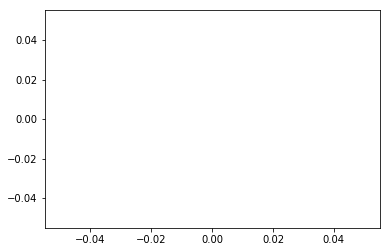

In [8]:
plt.plot(losses)

In [9]:
grad_approx = (loss_plus - loss) / 2e-4
loss_plus, loss, grad_approx

(0.2500001963111743, 0.2500001267597164, 0.00034775728963154506)

In [10]:
numerator = np.linalg.norm(grad_W_2 - grad_approx)
denominator = np.linalg.norm(grad_W_2) + np.linalg.norm(grad_approx)
numerator, denominator, numerator/denominator

(0.0008559820215119814, 0.0015553643233316072, 0.5503418129576604)

In [5]:
# Now try to wrap all of this up into an FC layer plus an output layer?
class FC_layer():
    def __init__(self, input_size, batch_size, layer_size, init_scale, activation = 'relu'):
        self.input_size = input_size
        self.batch_size = batch_size
        self.layer_size = layer_size
        self.weight = np.random.randn(layer_size, input_size) * init_scale
        self.bias = np.random.randn(layer_size,1) * init_scale
        self.activation = activation
        
    def relu(x, derivative = False):
        res = x
        if derivative == True:
            return (res > 0)*1
        else:
            return res * (res > 0)

    def sigmoid(x, derivative = False):
        res = 1/(1 + np.exp(-x))
        if derivative == True:
            return res * (1 - res)
        else:
            return res
    activation_zoo = {'relu': relu, 'sigmoid': sigmoid}
    
    def forward(input, activation):
        assert input.shape == (self.input_size, self.batch_size)
        activation_fn = activation_zoo[activation]
        W = self.weight
        b = self.bias
        z = W.dot(input) + b
        a = activation(z)
        cache = {
            'W': W,
            'b': b,
            'z': z,
            'a': a,
        }
        self.cache = cache
    
    def backward(upstream_gradient, cache):
        # Cache needs to be the previous layer's cache!
        activation_fn = activation_zoo[activation]
        grad_z = np.multiply(activation_fn(z, derivative=True), upstream_gradient)
        grad_b = (1/self.batch_size) * np.sum(grad_z, axis=1, keepdims = True)
        grad_w = upstream_gradient.dot(cache[a].T) # Use previous layers' activation
        return grad_z # That is the next upstream gradient to pass down.